# Time Series Prediction of Spot Exchange Rates

In this project, we analyse the time series of spot exchange rates from Euros to US dollars (USD) using Autoregressive Integrated Moving Average (ARIMA). The data is avaliable at [quandl](https://www.quandl.com/data/BOE/XUDLERD-Spot-Exchange-Rate-Euro-Into-Us).

## Imports

In [4]:
%matplotlib inline

# Ignore deprecated warning
import warnings
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd
import numpy as np
import quandl as qdl

# Matplotlib  for data visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Set font scale and style
sns.set(font_scale = 2)
sns.set_style('ticks')
plt.style.use('ggplot')
mpl.rcParams['font.family'] = 'serif'

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [5]:
# run some files containing custom functions
%run -i '../scripts/helper_functions.py'

## Load the Daily Exchange Rates For Euro Into US Dollars (USD)

We load the data using the quandl API

In [6]:
ts = qdl.get("BOE/XUDLERD", authtoken="oHeGAzShspf57uejGyqS") # Load from quandl API

In [7]:
ts.head() # Show the first 5 rows

,Value
Date,
1975-01-02,0.7633
1975-01-03,0.7585
1975-01-06,0.7524
1975-01-07,0.7510
1975-01-08,0.7554


In [8]:
ts.tail()

,Value
Date,
2019-09-27,0.9135
2019-09-30,0.9173
2019-10-01,0.9161
2019-10-02,0.9135
2019-10-03,0.9102


In [9]:
ts.index # Index is the correct format

DatetimeIndex(['1975-01-02', '1975-01-03', '1975-01-06', '1975-01-07',
               '1975-01-08', '1975-01-09', '1975-01-10', '1975-01-13',
               '1975-01-14', '1975-01-15',
               ...
               '2019-09-20', '2019-09-23', '2019-09-24', '2019-09-25',
               '2019-09-26', '2019-09-27', '2019-09-30', '2019-10-01',
               '2019-10-02', '2019-10-03'],
              dtype='datetime64[ns]', name='Date', length=11317, freq=None)

In [10]:
np.dtype(ts.Value) # Value is not a numeric value

dtype('float64')

In [11]:
ts.shape # Dimension of the data

(11317, 1)

## Time Series Plot

In [12]:
def plot_timeseries(timeseries, color = None, marker = None):
    """This function plots the time series"""
    
    # Set font size and background color
    sns.set(font_scale = 1.5)
    plt.style.use('ggplot')

    timeseries.plot(color = color,marker = marker,figsize=(15, 6))
    plt.xlabel('Year', fontsize = 20)
    plt.ylabel('Euro to USD', fontsize = 20)
    plt.grid(True)

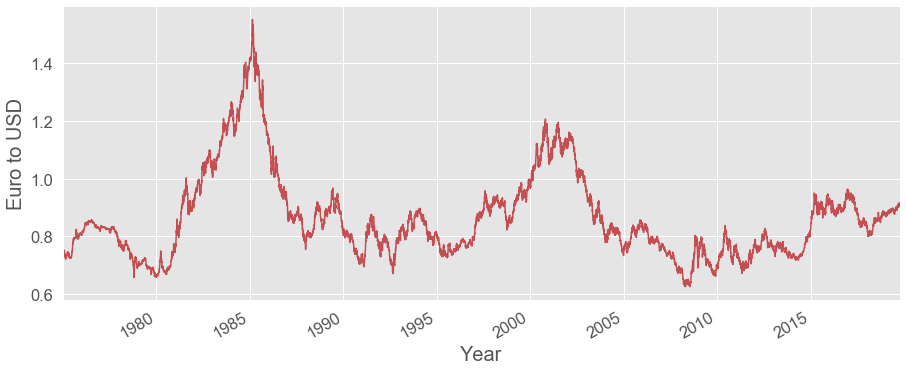

In [13]:
plot_timeseries(ts.Value,color = 'r',marker = None)

##  Resample into Weekly and  Average

In [14]:
ts_w = ts.resample('W').mean() 

In [15]:
ts_w.head()

,Value
Date,
1975-01-05,0.76090
1975-01-12,0.75346
1975-01-19,0.75546
1975-01-26,0.74388
1975-02-02,0.73902


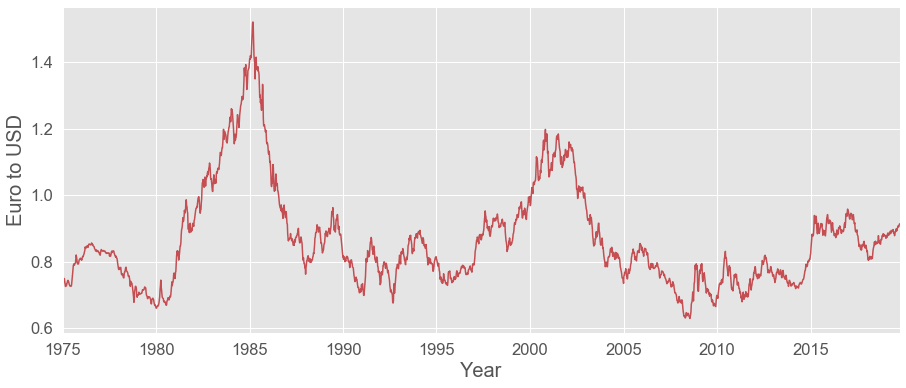

In [16]:
plot_timeseries(ts_w.Value,  color = 'r', marker = None)

## Stationarity Test ( Dickey-Fuller Test )

In [17]:
def plot_ts(timeseries, nlags = None):
    
    """This function plots the original time series together with rolling mean and standard deviations
    and its ACF and partial ACF. It also performs the Dickey-Fuller test"""
        
    # Set font size and background color
    sns.set(font_scale = 1.5)
    plt.style.use('ggplot')
    
    gridsize = (2, 2)
    fig = plt.figure(figsize=(15, 8))
    ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2)
    ax2 = plt.subplot2grid(gridsize, (1, 0))
    ax3 = plt.subplot2grid(gridsize, (1, 1))
    
    # Rolling statistic
    rolling_mean = timeseries.rolling(window = 24).mean()
    rolling_std = timeseries.rolling(window = 24).std()
    
    # Plot original time series and rolling mean & std
    timeseries.plot(color = 'r', ax = ax1, label = 'Original')
    rolling_mean.plot(color = 'b', ax = ax1, label = 'Rolling mean')
    rolling_std.plot(color = 'g', ax = ax1, label = 'Rolling Std')
    ax1.set_xlabel('Year', fontsize = 20)
    ax1.set_ylabel('Euro to USD', fontsize = 20)
    ax1.grid(True)
    ax1.legend(loc='best')
    
    # Plot ACF
    plot_acf(timeseries, lags = nlags, ax = ax2)
    ax2.set_xlabel('Lag', fontsize = 20)
    ax2.grid(True)
    
    # Plot PACF
    plot_pacf(timeseries, lags = nlags, ax = ax3)
    ax3.set_xlabel('Lag', fontsize = 20)
    ax3.grid(True)
    plt.tight_layout()
    plt.show()
    
    
    # Perform Dickey-Fuller test
    adf_results = adfuller(timeseries.values) 
    print('Test statistic:', adf_results[0])
    print('p-value:',adf_results[1])
    for key, value in adf_results[4].items():
        print('Critial Values (%s): %0.6f'%(key,value))

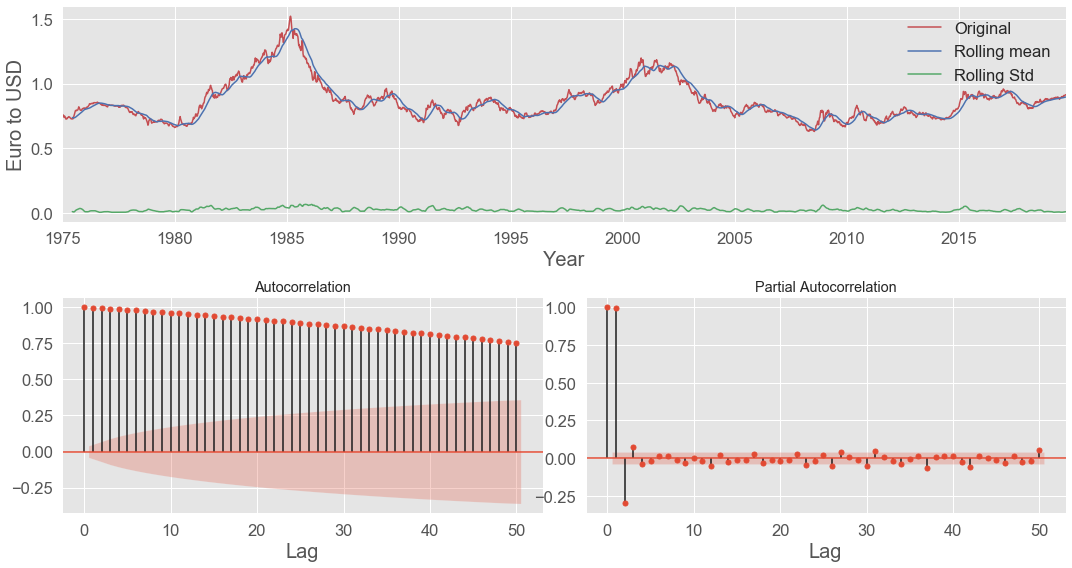

Test statistic: -2.1117260274727028
p-value: 0.23982572359224597
Critial Values (1%): -3.433156
Critial Values (5%): -2.862780
Critial Values (10%): -2.567430


In [18]:
plot_ts(ts_w.Value, nlags = 50)

We see that the autocorrelation function does not deccay rapidly for large lags.  The test statistic is also greater than the critical values and the p-value is greather than 0.05. These are the attributes of a nonstationary series.

## Log Transformation and DFT

In this section, we perform a logarithm transformation of the data and check for stationarity of the log transformed time series

In [19]:
ts_w['Value_log'] = np.log(ts_w['Value']) # take log of the time series

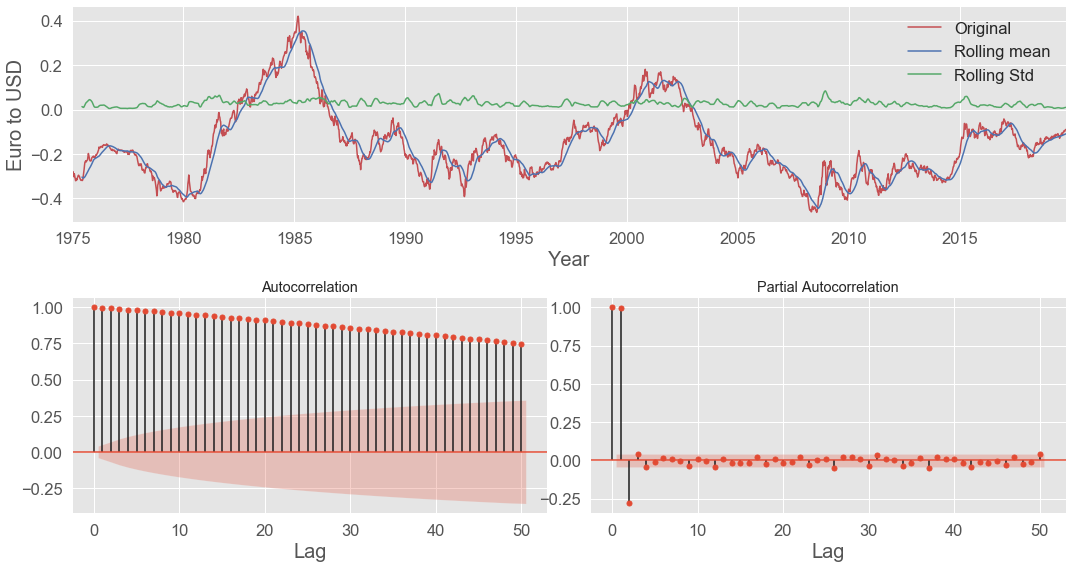

Test statistic: -2.275793060849959
p-value: 0.17989407206314206
Critial Values (1%): -3.433155
Critial Values (5%): -2.862779
Critial Values (10%): -2.567430


In [20]:
plot_ts(ts_w.Value_log, nlags = 50)

We see that the log transformation of the time series is still non-stationary

## Seasonal Decomposition

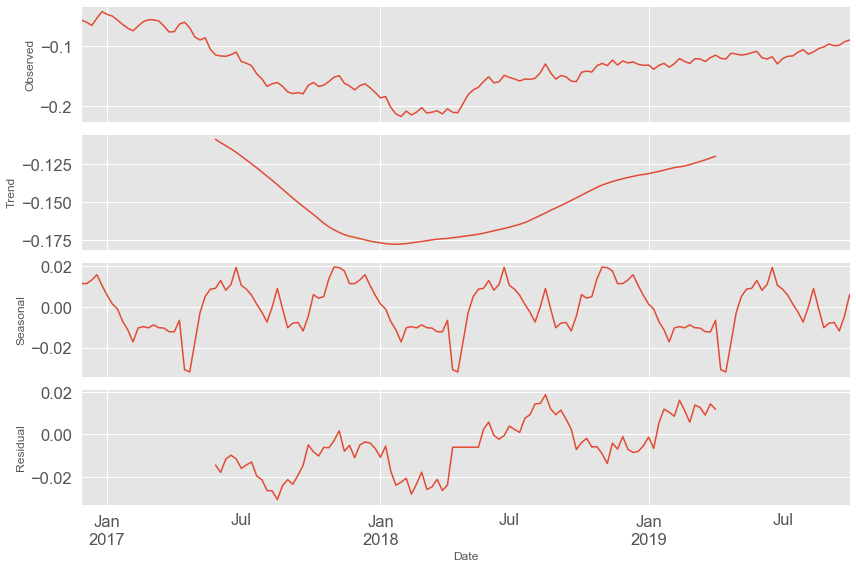

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams

rcParams['figure.figsize'] = 12, 8
plt.rcParams.update({'font.size':20})
plt.style.use('ggplot')

decomposition = seasonal_decompose(ts_w.Value_log[-150:], model='additive')
decomposition.plot()
plt.show()

## Differencing of Log Transformed Data

We now look at the first difference of the log transformed data, which signifies the growth rate of the exhchange rate from Euro to USD.

In [22]:
ts_w['Value_log_diff'] = ts_w['Value_log'] - ts_w['Value_log'].shift(1)

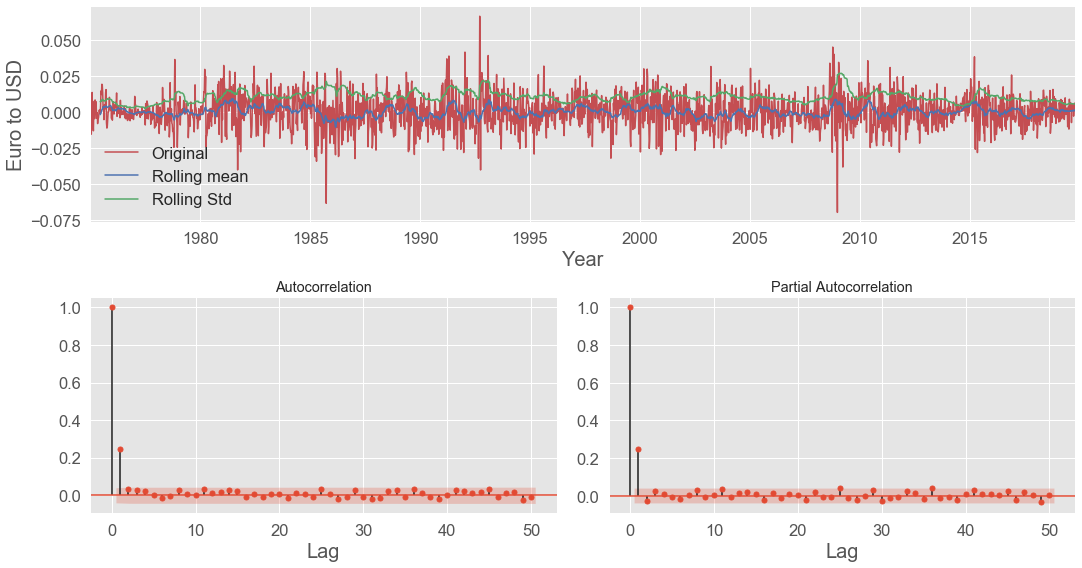

Test statistic: -37.54478683887766
p-value: 0.0
Critial Values (1%): -3.433155
Critial Values (5%): -2.862779
Critial Values (10%): -2.567430


In [23]:
plot_ts(ts_w.Value_log_diff.dropna(), nlags = 50)

We see that the test statistic is signicantly less than 1$\%$ critical value and the p-value is less than 0.05. Therefore, the time series is stationary with 99$\%$ confidence. The ACF and  Partial ACF of the differenced log transformed time series evidently decay quickly which corroborate the fact that the differenced log transformed time series  is stationary. 

#### Parameter Estimation
We will build the Autoregressive Integrated Moving Average (ARIMA) model, which comprises three parameters usually identified as (p,d,q). From the ACF and Partial ACF plots of the stationary series, we can now extract these parameters using the following criteria.

1. AR(p): The Partial ACF is finite and cut off after p lags

2. MA(q): The ACF is finite and cut off after q lags

3. d is the number of differencing needed to achieve stationarity.

In the present problem, we can clearly  see that p = q = d = 1 


## Training and Test Split

In [24]:
train_start,train_end = '1975-01-05','2017-12-31'
test_start,test_end = '2018-01-07','2019-07-14'

y_train = ts_w['Value_log'].loc[train_start:train_end]
y_test = ts_w['Value_log'].loc[test_start:test_end]

## Performance Metrics

In [25]:
def mae(y_test,y_pred):
    """Mean absolute error."""
    
    mae = np.abs(y_test-y_pred).mean() 
    return mae

def mse(y_test,y_pred):
    """Root mean squared error."""
    
    mse =  np.mean((y_test-y_pred)**2)
    return mse

def rmse(y_test,y_pred):
    """Root mean squared error."""
    
    rmse = np.sqrt( np.mean((y_test-y_pred)**2))
    return rmse

def r_squared(y_test,y_pred):
    """r squared (coefficient of determination)."""
    
    mse = np.mean((y_test-y_pred)**2) # mean squared error
    var = np.mean((y_test - np.mean(y_test))**2) # sample variance 
    r_squared = 1-mse/var 
    
    return r_squared

## ARIMA Model

In [26]:
model = ARIMA(y_train, order=(1, 1, 1))  
model_fit = model.fit() 

In [27]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.Value_log   No. Observations:                 2243
Model:                 ARIMA(1, 1, 1)   Log Likelihood                6894.009
Method:                       css-mle   S.D. of innovations              0.011
Date:                Fri, 04 Oct 2019   AIC                         -13780.018
Time:                        21:26:33   BIC                         -13757.156
Sample:                    01-12-1975   HQIC                        -13771.672
                         - 12-31-2017                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              4.043e-05      0.000      0.132      0.895      -0.001       0.001
ar.L1.D.Value_log     0.1430      0.086      1.659      0.097      -0.026       0.312
ma.L1.D.Value_log     0.

In [28]:
y_train.head()

Date
1975-01-05   -0.273253
1975-01-12   -0.283079
1975-01-19   -0.280428
1975-01-26   -0.295876
1975-02-02   -0.302430
Freq: W-SUN, Name: Value_log, dtype: float64

In [29]:
y_train_log_diff = y_train - y_train.shift(1) 

In [30]:
ts_train= pd.DataFrame({'fitted_value': model_fit.fittedvalues,
                       'actual_value': y_train_log_diff})

In [31]:
ts_train.tail()

,fitted_value,actual_value
Date,,
2017-12-03,-0.000728,-0.006586
2017-12-10,-0.001578,0.006988
2017-12-17,0.002014,0.003182
2017-12-24,0.000623,-0.006681
2017-12-31,-0.001757,-0.008031


In [32]:
# Compute the r2 and MAE
rmse_train = rmse(ts_train.fitted_value,ts_train.actual_value)
MAE_train = mae(ts_train.fitted_value,ts_train.actual_value)
print('Training RMSE: %.5f'%(rmse_train))
print('Training MAE: %.5f'%(MAE_train))

Training RMSE: 0.01119
Training MAE: 0.00848


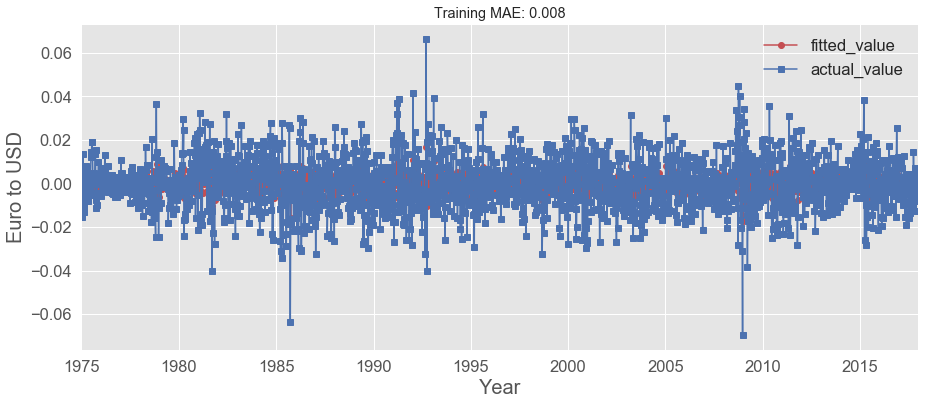

In [33]:
# Plot the result
plot_timeseries(ts_train.fitted_value,color = 'r', marker = 'o')
plot_timeseries(ts_train.actual_value,color = 'b', marker = 's')
plt.title('Training MAE: %.3f'%(MAE_train))
plt.legend(loc = 'best')

## Diagnostic Plot of Residuals for the Training Set

To check how well the model fits the data, we will conduct a residual diagnostic checks

In [34]:
def Diagnostic_Plot_train(fitted, nlags):
    
    sns.set(font_scale = 1.5)
    plt.style.use('ggplot')
    
    gridsize = (2, 2)
    fig = plt.figure(figsize=(20, 15))
    ax1 = plt.subplot2grid(gridsize, (0, 0))
    ax2 = plt.subplot2grid(gridsize, (0, 1))
    ax3 = plt.subplot2grid(gridsize, (1, 0))
    ax4 = plt.subplot2grid(gridsize, (1, 1))
    
    residual = model_fit.resid # compute the residual from ARIMA
    
    ax1.scatter(fitted[1:], residual)
    ax1.axhline(y=0, lw=2, color='k')
    ax1.set_xlabel('Fitted value', fontsize = 20)
    ax1.set_ylabel('Residual', fontsize = 20)
    ax1.set_title('Residual plot', fontsize = 20)
    
    from statsmodels.graphics.gofplots import qqplot
    qqplot(model_fit.resid, line='s', ax = ax2, color = 'b')
    ax2.set_title('Normal Q-Q', fontsize = 20)
    ax2.set_xlabel('Sample Quantiles', fontsize = 20)
    ax2.set_ylabel('Theoretical Quantiles', fontsize = 20)
    
    plot_acf(residual, lags = nlags, ax = ax3)
    ax3.set_xlabel('Lag', fontsize = 20)
    ax3.set_ylabel('ACF', fontsize = 20)
    ax3.set_title('Autocorrelation', fontsize = 20)
    ax3.set_xticks([1,5,10,15,20,25,30,35,40,45])
    ax3.set_xlim([.1,42])
    ax3.set_ylim([-0.2,0.2])
    
    plot_pacf(residual, lags = nlags,ax = ax4)
    ax4.set_xlabel('Lag', fontsize = 20)
    ax4.set_ylabel('PACF', fontsize = 20)
    ax4.set_title('Partial Autocorrelation', fontsize = 20)
    ax4.set_xticks([1,5,10,15,20,25,30,35,40,45])
    ax4.set_xlim([.1,42])
    ax4.set_ylim([-0.2,0.2])

The plots below show that the residuals of the fitted values has a random pattern within the parallel horizontal line, which induicates that they are normally distributed. We also see that the ACF and the PACF of the residuals are less than the 5% significant level. However, there are also few outliers from the top panel figures. In general, this result suggests that the  model fits the data reasonably well and its adequate  for forecasting future values.

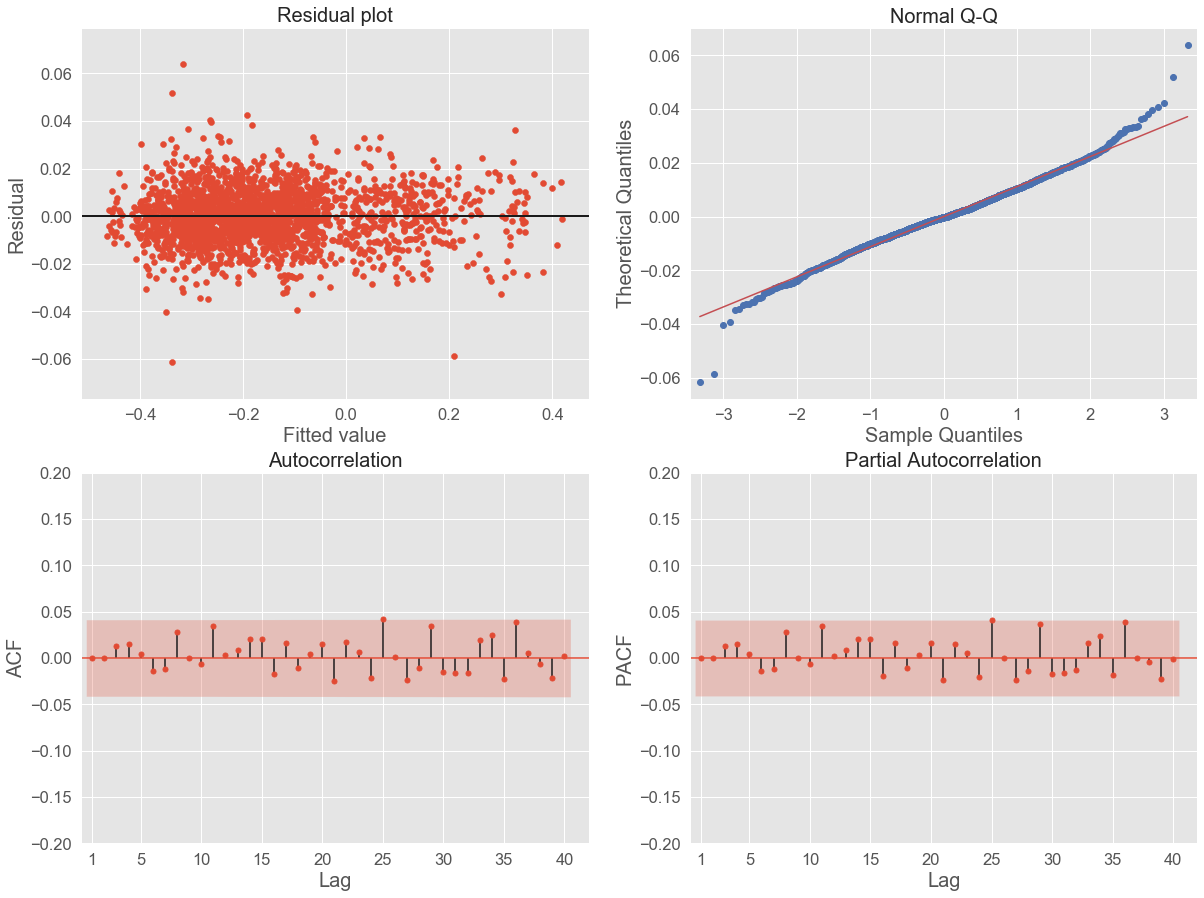

In [35]:
Diagnostic_Plot_train(y_train, nlags=40)

##  Model Out-of-Sample Forecasting

In [36]:
def test_forecast(train, test):
    
    X_pred = []
    X_true = []
    listcom = [x for x in train] # List comprehension of training data
    
    for i in range(len(test)):
        
        model = ARIMA(listcom, order=(2, 1, 1))  
        model_fit = model.fit() 
        pred = model_fit.forecast()[0]
        X_pred.append(float(pred))
        X_true.append(test[i])
        listcom.append(test[i])
        
    df = pd.DataFrame({'Actual':np.exp(X_true), 'Forecast':np.exp(X_pred)}, 
                      index = test.index)
    
    return df    

In [37]:
tf = test_forecast(y_train,y_test)

In [38]:
tf.head()

,Actual,Forecast
Date,,
2018-01-07,0.830225,0.836029
2018-01-14,0.832140,0.828508
2018-01-21,0.817120,0.832827
2018-01-28,0.808260,0.813209
2018-02-04,0.804760,0.806474


In [39]:
# Compute the r2 and MAE
r2 = r_squared(tf.Actual,tf.Forecast)
MAE = mae(tf.Actual,tf.Forecast)
print('Test R squared: %.5f'%(r2))
print('Test MAE: %.5f'%(MAE))

Test R squared: 0.94765
Test MAE: 0.00523


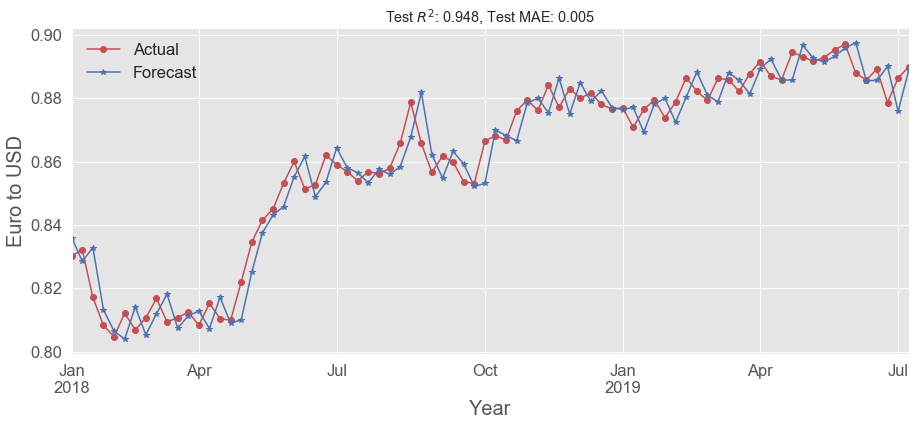

In [40]:
# Plot the result
plot_timeseries(tf.Actual,color = 'r', marker = 'o')
plot_timeseries(tf.Forecast,color = 'b', marker = '*')
plt.title('Test $R^2$: %.3f, Test MAE: %.3f'%(r2, MAE))
plt.legend(loc = 'best')

## Diagnostic Plot of Residuals for the Out-of-Sample Forecast

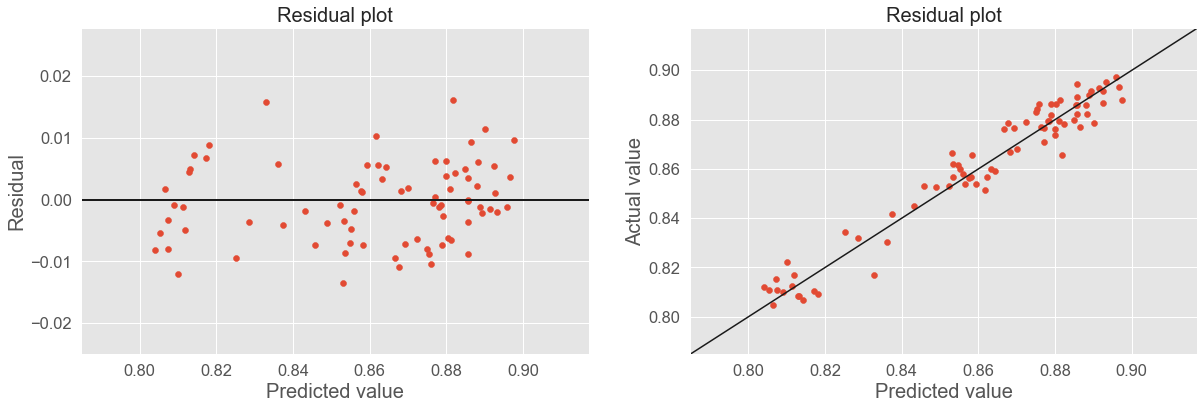

In [42]:
Diagnostic_Plot(tf, tf.Actual,tf.Forecast, nlags = 25)